In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import keras.backend as K

In [2]:
# Get the Dataset
df = pd.read_csv("ICICIBANK.NS.csv", na_values=['null'], index_col='Date', parse_dates=True, infer_datetime_format=True)
df.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-05-02,227.272720,229.854538,226.736359,227.709091,204.749756,9145994.0
2014-05-05,226.590912,232.181824,225.090912,227.718185,204.757950,14052241.0
2014-05-06,229.854538,232.727264,229.854538,231.927277,208.542603,7045379.0
2014-05-07,232.000000,232.181824,228.490906,231.027267,207.733383,28329075.0
2014-05-08,231.800003,235.781815,230.227264,234.363632,210.733337,16439945.0


In [3]:
print("Dataframe Shape:", df.shape)
print("Null Value Present:", df.isnull().values.any())


Dataframe Shape: (2130, 6)
Null Value Present: True


<Axes: xlabel='Date'>

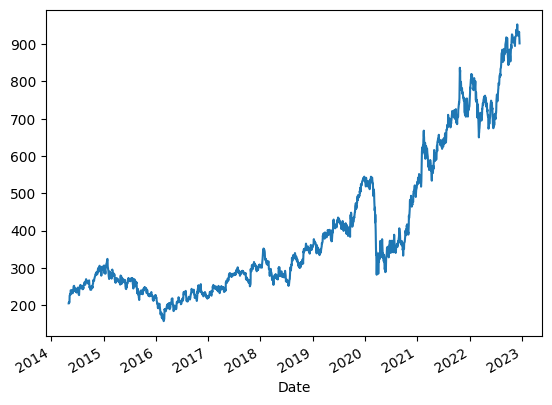

In [4]:
df['Adj Close'].plot()

In [6]:
# Set Target Variable
output_var = pd.DataFrame(df['Adj Close'])

# Selecting the Features
features = ['Open', 'High', 'Low', 'Volume']


In [7]:
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform = pd.DataFrame(data=feature_transform, columns=features, index=df.index)
feature_transform.head()

,Open,High,Low,Volume
Date,,,,
2014-05-02,0.075752,0.077056,0.080365,0.031883
2014-05-05,0.074888,0.080005,0.078247,0.048987
2014-05-06,0.079027,0.080696,0.084380,0.024561
2014-05-07,0.081748,0.080005,0.082624,0.098757
2014-05-08,0.081494,0.084567,0.084860,0.057310


In [8]:
from sklearn.model_selection import TimeSeriesSplit

timesplit = TimeSeriesSplit(n_splits=10)

for train_index, test_index in timesplit.split(feature_transform):
    X_train, X_test = feature_transform.iloc[train_index], feature_transform.iloc[test_index]
    y_train, y_test = output_var.iloc[train_index].values.ravel(), output_var.iloc[test_index].values.ravel()

    # Now you can use X_train, X_test, y_train, and y_test in your model training and evaluation

In [9]:
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

In [10]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.utils import plot_model

# Assuming trainX is your input data, adjust the shape as needed
# trainX = ...

lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')

# Plot the model
plot_model(lstm, show_shapes=True, show_layer_names=True)
lstm.save('filename.h5')

# Load the model using Keras's load_model function
lstm_from_keras = load_model('filename.h5')

# Use the loaded model to make predictions
predictions_from_keras = lstm_from_keras.predict(X_test)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 0s 2ms/step


In [11]:
history=lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

Epoch 1/100
243/243 [==============================] - 2s 2ms/step - loss: nan
Epoch 2/100
243/243 [==============================] - 1s 2ms/step - loss: nan
Epoch 3/100
243/243 [==============================] - 1s 2ms/step - loss: nan
Epoch 4/100
243/243 [==============================] - 1s 2ms/step - loss: nan
Epoch 5/100
243/243 [==============================] - 1s 2ms/step - loss: nan
Epoch 6/100
243/243 [==============================] - 1s 2ms/step - loss: nan
Epoch 7/100
243/243 [==============================] - 1s 2ms/step - loss: nan
Epoch 8/100
243/243 [==============================] - 1s 2ms/step - loss: nan
Epoch 9/100
243/243 [==============================] - 1s 2ms/step - loss: nan
Epoch 10/100
243/243 [==============================] - 1s 2ms/step - loss: nan
Epoch 11/100
243/243 [==============================] - 1s 3ms/step - loss: nan
Epoch 12/100
243/243 [==============================] - 1s 3ms/step - loss: nan
Epoch 13/100
243/243 [===========================

In [12]:
y_pred = lstm.predict(X_test)

# Inverse transform the predictions and actual values to get real stock prices
y_pred_actual = scaler.inverse_transform(np.hstack((np.zeros((y_pred.shape[0], 3)), y_pred)))
y_test_actual = scaler.inverse_transform(np.hstack((np.zeros((y_test.shape[0], 3)), y_test.reshape(-1, 1))))

# Print the predictions for the next 10 days
print("Predictions for the next 10 days:")
# Assuming next_10_days_features has the current date and other features for the next 10 days
next_10_days_features = feature_transform.iloc[-10:].values.reshape(10, 1, len(features))

# Predict the next 10 days
next_10_days_pred = lstm_from_keras.predict(next_10_days_features)


next_10_days_pred_df = pd.DataFrame(np.hstack((np.zeros((10, 3)), next_10_days_pred)), columns=features)

# Inverse transform the predictions for the next 10 days
next_10_days_pred_actual = scaler.inverse_transform(next_10_days_pred_df)

# Print the predictions for the next 10 days (Actual Values)
print("Predictions for the next 10 days (Actual Values):")
print(next_10_days_pred_actual)



7/7 [==============================] - 0s 5ms/step
Predictions for the next 10 days:
1/1 [==============================] - 0s 111ms/step
Predictions for the next 10 days (Actual Values):
[[ 1.67545456e+02  1.69045456e+02  1.64318176e+02 -4.16644959e+06]
 [ 1.67545456e+02  1.69045456e+02  1.64318176e+02 -4.08526565e+06]
 [ 1.67545456e+02  1.69045456e+02  1.64318176e+02 -4.05768944e+06]
 [ 1.67545456e+02  1.69045456e+02  1.64318176e+02 -4.09950673e+06]
 [ 1.67545456e+02  1.69045456e+02  1.64318176e+02 -4.15165310e+06]
 [ 1.67545456e+02  1.69045456e+02  1.64318176e+02 -4.10947783e+06]
 [ 1.67545456e+02  1.69045456e+02  1.64318176e+02 -4.11817940e+06]
 [ 1.67545456e+02  1.69045456e+02  1.64318176e+02 -4.18561464e+06]
 [ 1.67545456e+02  1.69045456e+02  1.64318176e+02 -4.08368515e+06]
 [ 1.67545456e+02  1.69045456e+02  1.64318176e+02 -4.00979834e+06]]


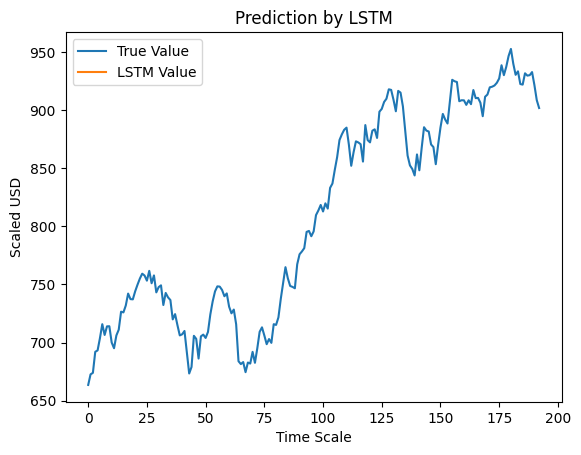

In [13]:
import matplotlib.pyplot as plt

plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title("Prediction by LSTM")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()


In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense
from keras.utils import plot_model

# Load your stock price data (replace 'your_data.csv' with your actual file)
# Make sure your CSV file has a column named 'Close' representing the closing prices
data = pd.read_csv('ICICIBANK.NS.csv')

# Use the 'Close' prices as the target variable
prices = data['Close'].values.reshape(-1, 1)

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

# Create sequences for training the LSTM model
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data)-seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Define the sequence length (adjust as needed)
sequence_length = 10

# Create sequences and targets
X, y = create_sequences(prices_scaled, sequence_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential()
model.add(LSTM(32, input_shape=(X.shape[1], X.shape[2]), activation='relu', return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Plot the model
plot_model(model, show_shapes=True, show_layer_names=True)

# Save the model
model.save('stock_price_prediction_model.h5')

# Load the model using Keras's load_model function
loaded_model = load_model('stock_price_prediction_model.h5')

# Assuming the current stock price is stored in 'current_price'
# Assuming the current stock price is stored in 'current_price'
current_price = 123.45  # Replace this with the actual current stock price

# Normalize the current price using Min-Max scaling
scaled_current_price = scaler.transform(np.array(current_price).reshape(1, -1))

# Initialize an array to store future predictions
future_predictions_actual = []

# Make 10 future predictions
for _ in range(10):
    # Extend the sequence with the scaled current price
    extended_sequence = np.append(prices_scaled[-sequence_length+1:], scaled_current_price)

    # Reshape the extended sequence to match the input shape of the LSTM model
    extended_sequence = extended_sequence.reshape(1, sequence_length, 1)

    # Use the loaded model to make predictions for the next day based on the extended sequence
    future_prediction = loaded_model.predict(extended_sequence)

    # Inverse transform the future prediction to get real stock prices
    future_prediction_actual = scaler.inverse_transform(future_prediction)

    # Append the actual future prediction to the list
    future_predictions_actual.append(future_prediction_actual[0, 0])

    # Update the current price for the next iteration
    current_price = future_prediction_actual[0, 0]

# Print the 10 future predictions
print("10 Future Predictions:")
print(future_predictions_actual)


Epoch 1/50
53/53 [==============================] - 3s 4ms/step - loss: nan
Epoch 2/50
53/53 [==============================] - 0s 8ms/step - loss: nan
Epoch 3/50
53/53 [==============================] - 0s 7ms/step - loss: nan
Epoch 4/50
53/53 [==============================] - 0s 4ms/step - loss: nan
Epoch 5/50
53/53 [==============================] - 0s 4ms/step - loss: nan
Epoch 6/50
53/53 [==============================] - 0s 9ms/step - loss: nan
Epoch 7/50
53/53 [==============================] - 0s 6ms/step - loss: nan
Epoch 8/50
53/53 [==============================] - 0s 4ms/step - loss: nan
Epoch 9/50
53/53 [==============================] - 0s 4ms/step - loss: nan
Epoch 10/50
53/53 [==============================] - 0s 4ms/step - loss: nan
Epoch 11/50
53/53 [==============================] - 0s 4ms/step - loss: nan
Epoch 12/50
53/53 [==============================] - 0s 4ms/step - loss: nan
Epoch 13/50
53/53 [==============================] - 0s 4ms/step - loss: nan
Epoch 14

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 21ms/step
10 Future Predictions:
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
